In [2]:
import numpy as np
from scipy.optimize import curve_fit
import torch
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.nn as nn
from tqdm import trange
import matplotlib.pyplot as plt


# Введение
В этом блокноте будет реализован новый подход к написанию нейросети. тестовая версия дала хороший результат, поэтому сделаем ее по человечески, вся информайия содержится в разности уровня, амплитуды и фазы сигналов (два синуса на 50 Гц), переделаем пространство входов с 2,5к до 48!

In [3]:
rel_path = '../Dataset/'

A_ref = np.loadtxt(f'{rel_path}RESULT0/Inductance_ALIJ.dat', skiprows=1, dtype=float)
PN_ref = np.loadtxt(f'{rel_path}RESULT0/ProbeVoltagePN.dat', skiprows=1, dtype=float, usecols=np.arange(1, 9))
PT_ref = np.loadtxt(f'{rel_path}RESULT0/ProbeVoltagePT.dat', skiprows=1, dtype=float, usecols=np.arange(1, 9))




In [ ]:
A = []
PN = []
PT = []
for i in range(1000):
    A.append(np.loadtxt(f"{rel_path}RESULT1/A{i}.dat", skiprows=1, dtype=float))
    PN.append(np.loadtxt(f"{rel_path}RESULT1/PN{i}.dat", skiprows=1, dtype=float, usecols=np.arange(1, 9)))
    PT.append(np.loadtxt(f"{rel_path}RESULT1/PT{i}.dat", skiprows=1, dtype=float, usecols=np.arange(1, 9)))

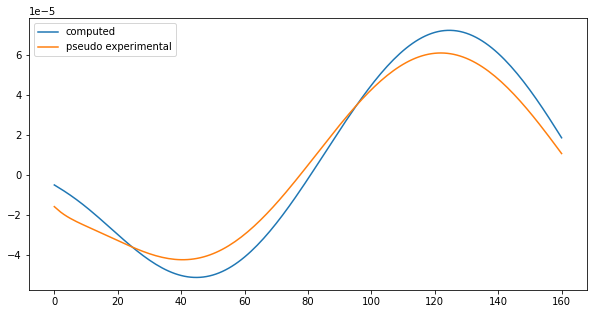

In [132]:
y_ref = PN_ref[:,0]
y_comp = PN[100][:,0]

plt.figure(figsize=(10,5))
plt.plot(y_ref, label='computed')
plt.plot(y_comp, label='pseudo experimental')
plt.legend()

p_comp=[-6.32006531e-05 -1.67948134e-01  8.09578263e-06]
p_ref= [-6.21753112e-05 -1.02878043e-01  7.97677044e-06]


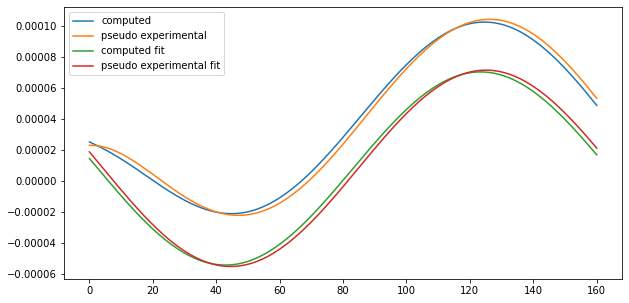

In [86]:
def fit_sine(x, Amp, phase, shift):
    return shift + Amp*np.sin(x + phase)
x = np.arange(len(y_comp))/len(y_comp)*2*np.pi

p_comp, _ = curve_fit(fit_sine, x, y_comp)
p_ref , _ = curve_fit(fit_sine, x, y_ref)

print(f"p_comp={p_comp}\np_ref= {p_ref}")
plt.figure(figsize=(10,5))
plt.plot(3e-5+y_ref, label='computed')
plt.plot(3e-5+y_comp, label='pseudo experimental')
plt.plot(fit_sine(x, *p_ref), label='computed fit')
plt.plot(fit_sine(x, *p_comp), label='pseudo experimental fit')
plt.legend()

Вот собственно все обоснование метода, теперь в трех числах храним всю полезную информацию, погнали делать датасеты

In [112]:
data_in = []
# TODO: Remove shift from p_ lists

x = np.arange(len(y_comp))/len(y_comp)*2*np.pi
def get_fitted(ydata):
    p, _ = curve_fit(fit_sine, x, ydata, 
                        bounds=((0,-np.pi, 0), (1, np.pi, 1)))
    return np.array(p)

p_pn_ref = []
p_pt_ref = []

for i in trange(PN_ref.shape[1]):
    p_pn_ref.append(get_fitted(PN_ref[:, i]))
    p_pt_ref.append(get_fitted(PT_ref[:, i]))

for i in trange(len(PN)):
    tmp = []
    pn = PN[i]
    pt = PT[i]
    for i in range(pn.shape[1]):
        tmp.append(get_fitted(pn[:, i]) - p_pn_ref[i])
        tmp.append(get_fitted(pt[:, i]) - p_pt_ref[i])
    
    data_in.append(tmp)

data_in = np.array(data_in)
print(f"shape = {data_in.shape}\nbefore normalization first element\n{data_in[0]}")

# two ways of normalization input data
# i prefered the first but will keep both
# becouse it provides dataset with not "all correct" normalisation

if True:
    in_mean = data_in.mean(axis=(0, 1))
    in_std = data_in.std(axis=(0, 1))
    for i in range(data_in.shape[2]):
        data_in[:,:,i] = (data_in[:,:,i]-in_mean[i])/in_std[i]
    print(f"input mean = {in_mean}, std = {in_std}\nFirst elem now\n{data_in[0]}")
    print(f"But total std={data_in.std()}")
else:
    in_mean = data_in.mean()
    in_std = data_in.std()
    data_in = (data_in-in_mean)/in_std
    print(f"input mean = {in_mean}, std = {in_std}\nFirst elem now\n{data_in[0]}")

100%|██████████| 1000/1000 [01:19<00:00, 12.56it/s]

shape = (1000, 16, 3)
before normalization first element
[[-2.64581763e-07 -5.49099227e-02 -1.51937551e-07]
 [-2.60612359e-06  2.14695103e-01 -2.23047115e-06]
 [ 9.45229823e-06  2.64994822e-02 -1.05597324e-07]
 [-2.41985654e-05 -2.67812157e-02  8.70892515e-07]
 [-8.90446789e-08  8.35241391e-04  9.74853451e-09]
 [ 1.55983960e-05  1.33137349e-02 -3.15595862e-08]
 [ 3.90237733e-06  7.17526354e-02  2.50529248e-08]
 [ 1.55819923e-06 -2.22116618e-01  1.76992068e-06]
 [-3.35327273e-07 -1.08382172e-01  1.44188332e-06]
 [-1.64296899e-07 -5.69542787e-02  3.79555362e-07]
 [-2.11119132e-06  8.68816519e-02  1.42669093e-07]
 [ 2.16414746e-06 -1.03195668e-01  8.14515196e-07]
 [ 5.29200141e-06 -3.75227527e-01 -3.74648999e-07]
 [-1.58920601e-06  5.26452133e-02 -3.39741781e-07]
 [ 1.11978132e-05 -1.39573848e+00 -7.03363585e-06]
 [-3.12420712e-06  1.73548969e-01 -1.07642700e-06]]
input mean = [ 6.01491874e-07 -1.95884552e-01 -2.52459574e-07], std = [9.31449453e-06 8.14062930e-01 2.13245725e-06]
First ele

In [183]:
data_out = []
Delta_A = np.array([x - A_ref for x in A])

# Leave only above diagonal elements
for i in trange(Delta_A.shape[0]):
    D_A = Delta_A[i]
    new = []
    for i in range(12):
        tmp = []
        for j in range(i):
            tmp.append(D_A[i][j])
        if tmp != []:
            for x in tmp:
                new.append(x)

    data_out.append(new)

data_out = np.array(data_out)
print(f"shape = {data_out.shape}, before normalization first element\n{data_out[0]}")

out_mean = data_out.mean()
out_std = data_out.std()
data_out = (data_out-out_mean)/out_std
print(f"output mean={out_mean}, std={out_std}\nAfter normalization first elem\n{data_out[0]}")

100%|██████████| 1000/1000 [00:00<00:00, 30295.81it/s]

shape = (1000, 66), before normalization first element
[ 1.40839e-02  1.81872e-02  6.02410e-02  2.79621e-02  4.94368e-02
  1.60823e-01  1.84434e-02  5.37500e-04  2.98102e-02  4.75940e-02
  1.46799e-02  7.34000e-05  1.26224e-02  5.75080e-02  1.61424e-01
  1.50996e-02  1.86014e-03  6.64140e-03  2.53182e-02  2.20172e-02
  1.37447e-01  2.31335e-02  3.47340e-04  1.12245e-03  2.78050e-03
  2.45512e-02  6.01699e-02  4.60160e-02  5.30640e-03  8.28900e-05
  6.64060e-04  1.15500e-03  4.30449e-02  2.99650e-02  1.63345e-01
  8.21040e-02  4.36260e-03  3.08337e-03  1.32570e-02  4.41420e-03
  3.66661e-02  1.49355e-01  1.14327e-01  1.76046e-02  1.57613e-01
  9.36346e-03 -2.77003e-02 -3.66179e-02 -2.37810e-03  1.12090e-17
  3.25487e-02  3.13001e-02  1.10121e-02  1.93270e-03  2.04538e-02
  5.11489e-03 -3.44601e-02 -2.93780e-02 -1.88020e-01  0.00000e+00
  1.30563e-01  7.31780e-02  3.85353e-02  3.83687e-02  5.59730e-02
  3.32460e-03]
output mean=0.028262672460606063, std=0.0636566134971504
After normaliza

Датасеты готовы переходим к организации нейросети, будем использовать самую простую архитектуру Feed Forward (полносвязная сеть)

In [202]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#reshaping data_in (1000, 16, 3) -> (1000, 48) 
# data_in = data_in.reshape((data_in.shape[0], data_in.shape[1]*data_in.shape[2]))
U_train, U_test, A_train, A_test = train_test_split(
                                    data_in, data_out, test_size=0.2, )

U_train = torch.from_numpy(U_train).to(dtype=torch.float32).to(device)
U_test = torch.from_numpy(U_test).to(dtype=torch.float32).to(device)
A_train = torch.from_numpy(A_train).to(dtype=torch.float32).to(device)
A_test = torch.from_numpy(np.array(A_test)).to(dtype=torch.float32).to(device)

In [196]:
hidden = 100
class Net(nn.Module):
    def __init__(self, device, U_shape, A_shape):
        super(Net, self).__init__()

        self.input_shape = U_shape
        self.output_shape = A_shape
        self.fcFF = nn.Sequential(
            nn.Linear(self.input_shape, hidden),
            nn.GELU(),
            nn.Linear(hidden, 2*hidden),
            nn.GELU(),
            nn.Linear(2*hidden, 2*hidden),
            nn.GELU(),
            nn.Linear(2*hidden, 2*hidden),
            nn.GELU(),
            nn.Linear(2*hidden, hidden),
            nn.GELU(),
            nn.Linear(hidden, self.output_shape)
        ).to(device)

    def forward(self, U):
        return self.fcFF(U)


def compute_loss(A, A_true):
    return torch.sum((A- A_true)**2)

def accuracy(A, A_true):
    acc_min = 1e-2
    return torch.sum(torch.abs(A - A_true) < acc_min)/torch.prod(torch.tensor(A.shape))

def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

net = Net(device, data_in.shape[1], data_out.shape[1])
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5, amsgrad=False, weight_decay=0)
net

Net(
  (fcFF): Sequential(
    (0): Linear(in_features=48, out_features=100, bias=True)
    (1): GELU()
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): GELU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): GELU()
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): GELU()
    (8): Linear(in_features=200, out_features=100, bias=True)
    (9): GELU()
    (10): Linear(in_features=100, out_features=66, bias=True)
  )
)

100%|██████████| 500000/500000 [1:27:00<00:00, 95.78it/s]


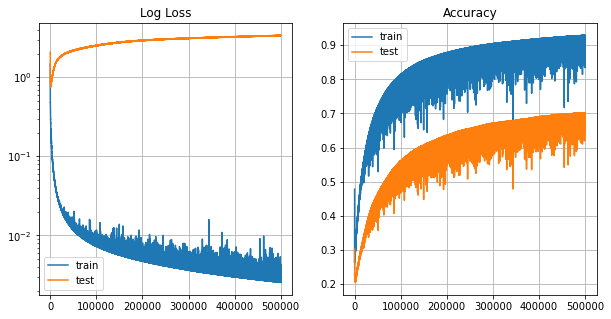

In [203]:
L_train, L_test, acc_train, acc_test = [], [], [], []
L_test = []
batch_size = 200

for epoch in trange(500000):
    net.train(True)
    l = 0.0
    acc = 0.0

    for U_t, A_t in iterate_minibatches(U_train, A_train, batch_size):
        A_h = net.forward(U_t)
        loss = compute_loss(A_h, A_t)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        l += loss.detach().cpu().numpy()
        acc += accuracy(A_h, A_t).cpu().numpy()
            

    L_train.append(l/A_train.shape[0])
    acc_train.append(acc/(U_train.shape[0]/batch_size))

    net.train(False)
    A_h = net.forward(U_test)
    with torch.no_grad():
        L = compute_loss(A_h, A_test).cpu().numpy()
    L_test.append(L/A_test.shape[0])
    acc_test.append(accuracy(A_h, A_test).cpu().numpy())

torch.save(net.state_dict(), r'dump_configurations\light_net_1000000.torch')

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))

ax1.plot(L_train, label='train')
ax1.plot(L_test, label='test')
ax1.grid()
ax1.set_title('Log Loss')
ax1.legend()
ax1.set_yscale('log')

ax2.plot(acc_train, label='train')
ax2.plot(acc_test, label='test')
ax2.grid()
ax2.set_title('Accuracy')
ax2.legend()

plt.show()

In [128]:
#save result
torch.save(net.state_dict(), r'dump_configurations\light_net_500.torch')

А теперь вернемся к начальному примеру и попробуем продемонстрировать результат работы сети

In [208]:
comp = []
for i in range(8):
    comp.append(p_pn_ref[i])
    comp.append(p_pt_ref[i])
comp = np.array(comp)

exp = data_in[100].reshape((16, 3))*in_std + in_mean + comp

for_net = (exp - comp - in_mean)/in_std
for_show = torch.from_numpy(for_net.reshape((48))).to(dtype=torch.float32).to(device)
net_pred_A = net(for_show)*out_std + out_mean

net_pred_A, data_out[100]

(tensor([ 1.2029e-02,  1.6360e-02,  3.8126e-02,  3.1034e-02,  3.4981e-02,
          9.1076e-02,  2.2770e-02,  2.4050e-02,  4.4506e-02,  2.5119e-01,
          2.7404e-02,  1.1483e-02,  5.3611e-03,  2.0795e-02,  5.3898e-03,
          1.5069e-02,  2.9442e-03,  1.8746e-03,  2.5387e-02,  3.0251e-02,
          9.1393e-02,  1.1692e-02,  1.8355e-03,  2.8941e-03,  1.3171e-02,
          1.7833e-02,  2.5450e-02,  1.1147e-01,  1.5485e-02,  2.1408e-03,
          2.9727e-03,  5.7252e-03,  2.9095e-02,  5.8722e-02,  1.4442e-01,
          6.6534e-02,  1.8640e-02,  4.1647e-03,  1.0121e-02,  3.5376e-02,
          6.7503e-02,  4.6351e-02,  2.5506e-01,  5.5207e-02,  1.8822e-01,
          5.1003e-03, -6.8229e-02, -4.2143e-02, -2.0998e-02, -1.6686e-05,
          1.7391e-02,  1.3145e-02,  2.3608e-03,  1.5351e-02,  3.9304e-03,
          3.2304e-03, -1.9230e-02, -3.3698e-02, -3.7228e-01, -1.9744e-07,
          7.3602e-02,  2.6384e-03,  2.0036e-02,  6.1218e-02,  9.1658e-02,
          3.8937e-02], device='cuda:0'

In [204]:
net(for_show), data_out[100]

(tensor([-0.2550, -0.1870,  0.1550,  0.0435,  0.1055,  0.9868, -0.0863, -0.0662,
          0.2552,  3.5020, -0.0135, -0.2636, -0.3598, -0.1173, -0.3593, -0.2073,
         -0.3977, -0.4145, -0.0452,  0.0312,  0.9917, -0.2603, -0.4152, -0.3985,
         -0.2371, -0.1638, -0.0442,  1.3071, -0.2007, -0.4104, -0.3973, -0.3540,
          0.0131,  0.4785,  1.8248,  0.6012, -0.1512, -0.3786, -0.2850,  0.1117,
          0.6164,  0.2842,  3.5628,  0.4233,  2.5128, -0.3639, -1.5158, -1.1060,
         -0.7739, -0.4442, -0.1708, -0.2375, -0.4069, -0.2028, -0.3822, -0.3932,
         -0.7461, -0.9734, -6.2923, -0.4440,  0.7123, -0.4025, -0.1292,  0.5177,
          0.9959,  0.1677], device='cuda:0', grad_fn=<AddBackward0>),
 array([-0.252751  , -0.18822981,  0.15491442,  0.04583542,  0.10577892,
         0.98659549, -0.08911678, -0.06388138,  0.25516481,  3.50102394,
        -0.01922616, -0.271145  , -0.36061567, -0.11016408, -0.36405758,
        -0.21040818, -0.40630598, -0.41491168, -0.04070547,  0.

In [206]:
_tmp = np.zeros((12, 12))
idx = 0
for i in range(12):
    for j in range(i):
        _tmp[i, j] = net_pred_A[idx]
        _tmp[j, i] = net_pred_A[idx]
        idx += 1

_tmp = A_ref + _tmp
np.savetxt('A.txt', _tmp, fmt='  %11.6e')

Теперь отправляем полученный файл А.txt в код и посмотрим что он выдаст

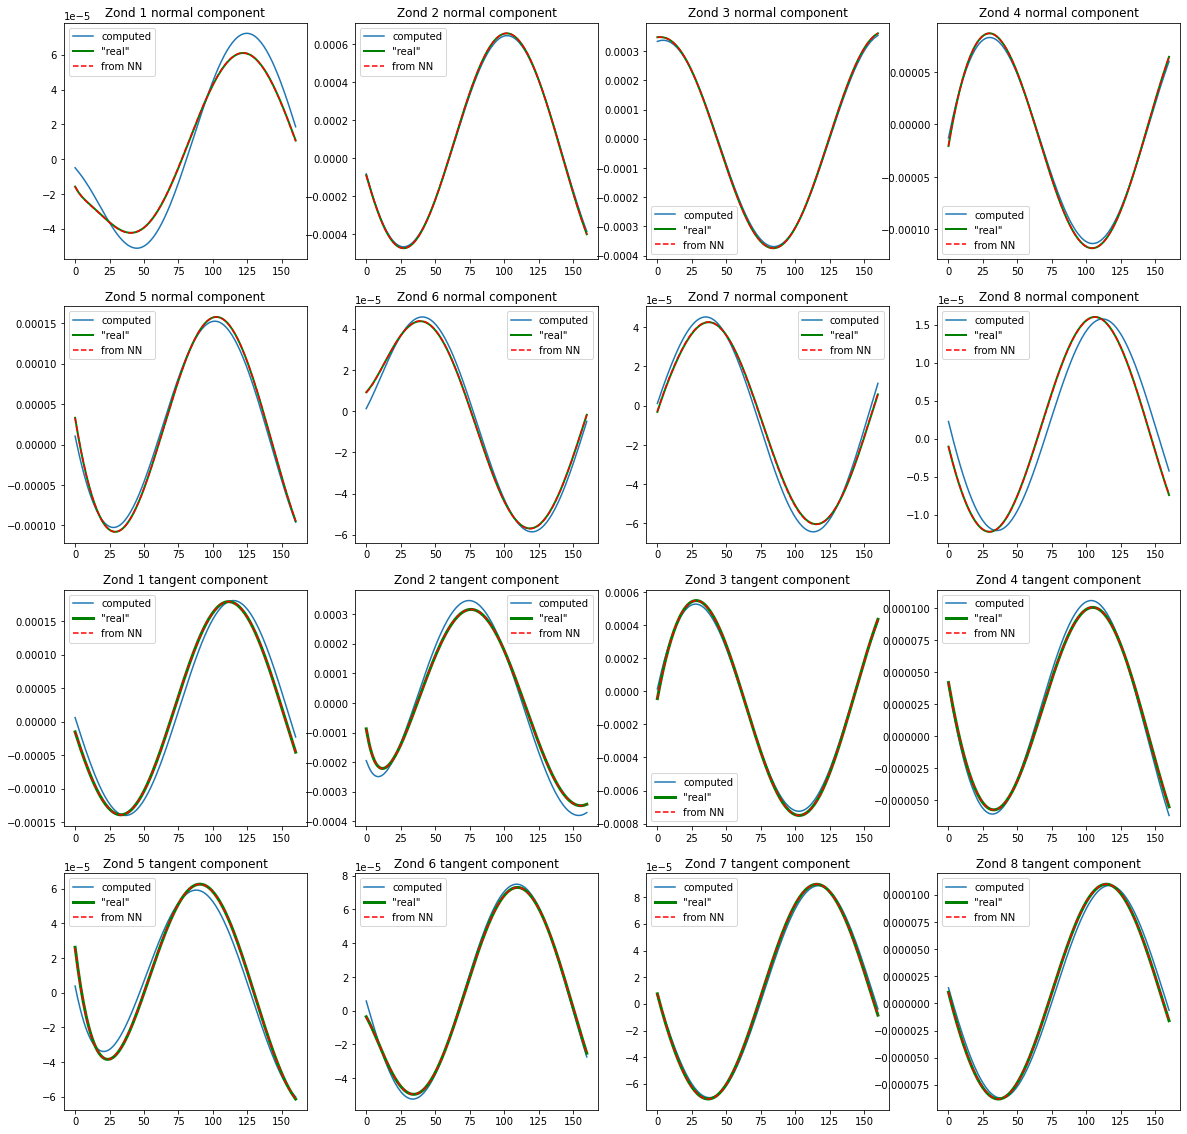

In [214]:
i=10000
net_PN = np.loadtxt(f"{rel_path}RESULT1/PN{i}.dat", skiprows=1, dtype=float, usecols=np.arange(1, 9))
net_PT = np.loadtxt(f"{rel_path}RESULT1/PT{i}.dat", skiprows=1, dtype=float, usecols=np.arange(1, 9))
ig, ax = plt.subplots(4, 4, figsize=(20, 20))


for i in range(2):
    for j in range(4):
        ax[i][j].set_title(f'Zond {1+4*i+j} normal component')
        ax[i][j].plot(PN_ref[:, 4*i+j], label='computed')
        ax[i][j].plot(PN[100][:, 4*i+j], 'g', label = '"real"', linewidth=2)
        ax[i][j].plot(net_PN[:, 4*i+j], 'r--', label='from NN')
        ax[i][j].legend()
        
        
        ax[i+2][j].set_title(f'Zond {1+4*i+j} tangent component')
        ax[i+2][j].plot(PT_ref[:, 4*i+j], label='computed')
        ax[i+2][j].plot(PT[100][:, 4*i+j], 'g', label = '"real"', linewidth=3)
        ax[i+2][j].plot(net_PT[:, 4*i+j], 'r--', label='from NN')
        ax[i+2][j].legend()


Попробуем применить обученную сеть для фита эксперимента

In [12]:
comp[:, 0]

array([0.      , 0.000125, 0.00025 , 0.000375, 0.0005  , 0.000625,
       0.00075 , 0.000875, 0.001   , 0.001125, 0.00125 , 0.001375,
       0.0015  , 0.001625, 0.00175 , 0.001875, 0.002   , 0.002125,
       0.00225 , 0.002375, 0.0025  , 0.002625, 0.00275 , 0.002875,
       0.003   , 0.003125, 0.00325 , 0.003375, 0.0035  , 0.003625,
       0.00375 , 0.003875, 0.004   , 0.004125, 0.00425 , 0.004375,
       0.0045  , 0.004625, 0.00475 , 0.004875, 0.005   , 0.005125,
       0.00525 , 0.005375, 0.0055  , 0.005625, 0.00575 , 0.005875,
       0.006   , 0.006125, 0.00625 , 0.006375, 0.0065  , 0.006625,
       0.00675 , 0.006875, 0.007   , 0.007125, 0.00725 , 0.007375,
       0.0075  , 0.007625, 0.00775 , 0.007875, 0.008   , 0.008125,
       0.00825 , 0.008375, 0.0085  , 0.008625, 0.00875 , 0.008875,
       0.009   , 0.009125, 0.00925 , 0.009375, 0.0095  , 0.009625,
       0.00975 , 0.009875, 0.01    , 0.010125, 0.01025 , 0.010375,
       0.0105  , 0.010625, 0.01075 , 0.010875, 0.011   , 0.011

In [4]:
net = torch.load(r'dump_configurations\light_net_1000000.torch')

In [23]:
comp = np.loadtxt(f'{rel_path}RESULT0/ProbeVoltagePT.dat', skiprows=1, dtype=float)
comp = comp - comp.mean(axis=0)
exp_data = np.loadtxt('exp_data\Exp_Data_PF5.dat')
exp_data -= exp_data.mean(axis=0)

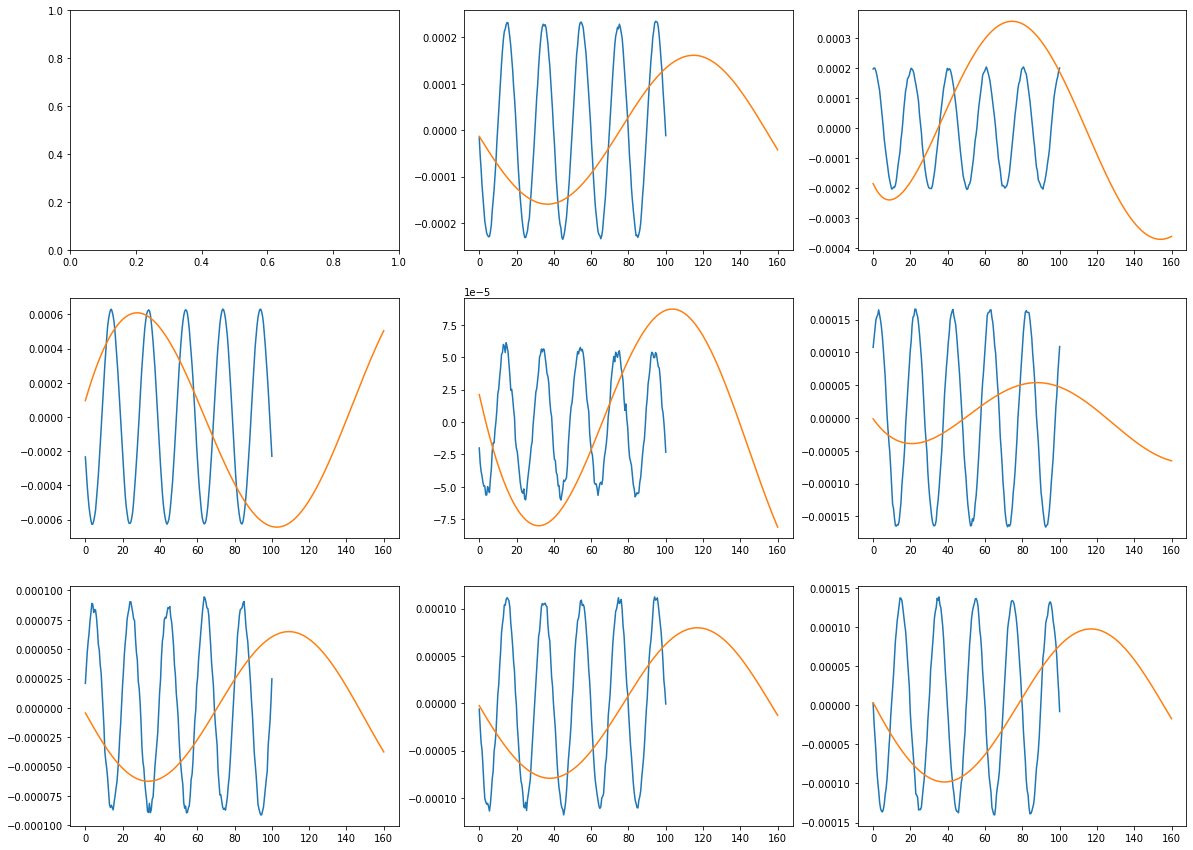

In [24]:
fig, ax = plt.subplots(3, 3, figsize=(20, 15))

for i in range(1, 9):
    j = i//3
    k = i%3
    ax[j][k].plot(exp_data[:, 0]-exp_data[0, 0], exp_data[:, i])
    ax[j][k].plot(comp[:, i])
